# Coursework 1 : The three body problem

You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

## Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

## Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


## Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


# Topics in Scientific Computing Coursework (230793835)


# 1.0 Imported libraries

Before we begin, please see the libraries we have imported from numpy and scipy. These allow us to use mathematical operations to solve our stellar system. There are comments to show why they have been imported into this notebook.

In [1]:
import numpy as np #allows us to carry out various mathematical methods and include multi-dimensional arrays (among other mathematical objects).

import matplotlib.pyplot as plt #adds the ability to plot

from matplotlib.pyplot import cm # allows for new colours when plotting

from scipy.integrate import solve_ivp # allows us to use solve_ivp to solve the DE of the system
                                      # Solve_ivp uses the RK45 method.

import unittest # allows us to use the isinstance function, which checks whether an object is an instance of a class.


# 2.0 Setting up our classes

## 2.1 The 'Star' class

In this section, you will see the construction of the 'Star' class. This holds data about a typical star, such as mass, position and velocity. You will see that I have provided asserts to ensure negative masses cannot be used, letters cannot be inserted where floating point numbers are required, and that the user cannot input a position or velocity array not in two-dimensions. The error messages are intended to steer the user in the right direction. 

## 2.2 The 'StellarSystem' class

The Stellar System class is a class which allows the user to add/remove instances of stars (using the 'add_star' and 'remove_star' methods respectively. Once a sufficient number of stars has been added, the user can plot trajectories and phase portraits once they have been solved by either the 'integrate_using_solve_ivp' or 'integrate_using_midpoint' method. There are checks in place to ensure the user has first collated all of the star's initial conditions as well as further checks to test whether the system's system of coupled ODEs has been solved by either aforementioned method. 

## 2.3 The 'calculate_stellar_system_dydt' method

The 'calculate_stellar_system_dydt' method requires further explanation. Let us first begin by explaining the equations of motion for an N-body star system according to Newtonian mechanics (where each star in the system is indexed i such that $i \in [1, 2, ...., N]$):

$$\frac{d^2x_i}{dt^2} = \sum_{j=1, j\neq i}^{N} \frac{GM_j}{r_{ij}^2} \cos(\theta)$$


$$\frac{d^2y_i}{dt^2} = \sum_{j=1, j\neq i}^{N} \frac{GM_j}{r_{ij}^2} \sin(\theta)$$

where: 
- $x_i$ represents horizontal position of star i 
- $y_i$ represents vertical position of star i. 
- $M_j$ is the mass of star j
- $\theta$ is the angle between star i and star j
- $r_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$

Now, we know from Pythaogras' thereom and elementary trigonometry that $\cos(\theta) = \frac{x_j - x_i}{r_{ij}}$ and $\sin(\theta) = \frac{y_j - y_i}{r_{ij}}$. Also, we cleverly choose our initial conditions such that dimensional analysis allows us to set $G=1$. So, let us substitute these values into the equations above.

$$\frac{d^2x_i}{dt^2} = \sum_{j=1, j\neq i}^{N} \frac{M_j (x_j - x_i)}{r_{ij}^3}$$


$$\frac{d^2y_i}{dt^2} = \sum_{j=1, j\neq i}^{N} \frac{M_j (y_j - y_i)}{r_{ij}^3}$$

From here, we have to explain how we can solve second-order ODEs using numerical methods. We have learned that we can seperate the second-order ODE into two first-order ODEs. For instance:

$$\frac{d^2u}{dt^2} = \ ...$$

can be dealt with by introducing a variable $v$ such that $v = \frac{du}{dt}$ and the equation of one second-order ODE becomes two first-order ODEs:  

$$ \frac{dv}{dt} = \ ...$$
$$ v = \frac{du}{dt}$$

However, here, we have two second-order ODEs for each star. So, we need to consider splitting each second-order ODE into two first-order ODEs. This will give us four first-order ODEs for each star. Such a system of ODEs, for the $i$-th star, can be represented as follows:

$$ \frac{d }{dt} \begin{pmatrix}
\dot{x_i} \\
x_i  \\
\dot{y_i}  \\
y_i 
\end{pmatrix} = \begin{pmatrix}
\sum_{j=1, j\neq i}^{N} \frac{M_j (x_j - x_i)}{r_{ij}^3} \\
\dot{x_i}  \\
\sum_{j=1, j\neq i}^{N} \frac{M_j (y_j - y_i)}{r_{ij}^3}  \\
\dot{y_i} 
\end{pmatrix} $$ 

Our 'calculate_stellar_system_dydt' method takes the initial conditions as a $1 \times 4 N$ vector and returns the right-hand side of this equation for $N$ stars. For instance, if we had a two-star system, this vector would have a length of eight rather than four. It is important to note that the intiial conditions are first collated by the 'collate_initial_conditions' method. Though you must manually enter the 'collate_initial_conditions', the consequences of adding more stars on the dimensions of the dydt output is taken care of by the class itself.

The differential equation is then taken by either 'integrate_using_solve_ivp' or 'integrate_using_midpoint' depending on the user's choice.

## 2.4 The 'integrate_using_solve_ivp' method

This method enables the user to solve an 'initial value problem'; a differential equation given a set of initial conditions. It takes the differential equation defined above, a set of times where the differential equation should be evaluated between, and the 'collated' initial conditions which we discussed above. It then provides us with a solution curve to the differential equation (with the same dimensions as the initial conditions vector) alongside a time solution of where the differential equation has been evaluated. One may achieve more precise results by altering the 'rtol' parameter, In this case, I had to amend the rtol parameter of solve ivp from the default to 1e-10. The rtol parameter is the amount of error which solve_ivp permits before altering its step size. Obviously, the smaller the rtol parameter, the less error allowed. Hence, the smoother the solution curve.

## 2.5 The 'integrate_using_midpoint' method

This method enables the user to solve the differential equation using the midpoint method. The process for one dimension is given by: 

$$y_{n+1}=y_{n}+hf\left(t_{n}+{\frac {h}{2}},y_{n}+{\frac {h}{2}}f(t_{n},y_{n})\right) $$

where we of course have an initial condition $y(t_{0})=y_{0}$ and can represent the one-dimensional ODE as $y'(t)=f(t,y(t))$. 

However, in our case, we have more than one-dimension. In fact, we have $1 \times 4 N$ dimensions for an $N$-star system. Therefore, the midpoint method produced in the code accounts for that.

In [2]:
class Star :

    """
    This is a class which holds information about various stellar objects found 
    within the observable universe. It holds a star's initial position and initial velocity
    in two dimensions.
    
    attributes: mass, initial position, initial velocity
                
    There are no methods associated with this class. This is because the system of ODEs we need to solve are coupled.
    Therefore, we must collate the initial conditions of the system before we can solve the system. 
    
    """

    # The below function is our constructor function for the Star class
    def __init__(self, mass=0.0, initial_position=np.array([0.0, 0.0]), 
                 initial_velocity=np.array([0.0, 0.0])):
        
        self.mass = mass
        self.initial_position = initial_position
        self.initial_velocity = initial_velocity
        self._solution_x_velocity = []
        self._solution_x_position = []
        self._solution_y_velocity = []
        self._solution_y_position = []
        
        assert isinstance(mass, (int, float)), 'The mass of the star must be a floating point number o'
        assert mass >= 0.0, 'Mass of the star must be non-negative'
        assert np.shape(initial_position) == (2,), 'The initial position must be a 1 x 2 vector. The first element is the x-component of the displacement and the second element is the y-compoenent of the displacement.' 
        assert np.shape(initial_velocity) == (2,), 'The initial position must be a 1 x 2 vector. The first element is the x-component of the velocity and the second element is the y-component of the velocity.' 
        assert isinstance(initial_position[0], float), 'The initial position in the x-direction must be a floating point number.'
        assert isinstance(initial_position[1], float), 'The initial position in the y-direction must be a floating point number.'
        assert isinstance(initial_velocity[0], float), 'The initial velocity in the x-direction must be a floating point number.'
        assert isinstance(initial_velocity[1], float), 'The initial velocity in the y-direction must be a floating point number.'

class StellarSystem :

    """
    This is a class which allows one to add stars to its system and contains explicit methods to
    integrate the ODEs provided for stellar orbits. There exists various checks to see whether the initial 
    conditions have been collated prior to solving as well as whether the system has been solved before plotting.
    
    attributes: stars (a list which stores all of the instances of stars you choose to add/remove), 
                initial conditions (which stores the initial velcoities and positions of the stars involved).
                
    methods: add_star (which allows the user to add a star), remove_star(which allows the user to remove a star), 
             calculate_stellar_system_dydt, collate_initial_conditions, integrate_using_solve_ivp, plot_solution, 
             plot_phase_portraits, test_convergence_of_midpoint.
    
    """
    
    # The below function is our constructor function
    def __init__(self):
        
        self.stars = [] # This allows us to store our stars in our stellar system
        self.initial_conditions = [] # This allows us to store each star's initial conditions, which are then placed 
                                     # into the DE solver
        self._is_initialised = False # This checks whether the individual star's initial conditions have been collated 
                                     # by the system
        self._is_solved = False #This is an indicator to check whether the system's ODEs have been solved.
        self._y_solution = [] #This stores the solution to the DE specified in the 'calculate_stellar_system_dydt' method.
    

    def add_star(self, aStar):
        """This method allows you to add a star to an instance of your stellar system"""
        if isinstance(aStar, Star):
            self.stars.append(aStar)
            print(f"The star with mass {aStar.mass} units has successfully been added to your {len(self.stars)}-star system situated in a galaxy far, far away!" )
        else:
            raise ValueError('The stellar system can only contain stars.')

    def remove_star(self, aStar):
        """This method allows you to remove an already existing star from an instance of your stellar system"""
        assert aStar in self.stars, 'Please ensure your star belongs to this stellar system.'
        assert len(self.stars) > 0, 'Please ensure your stellar system actually contains stars, before attempting to remove one.'
        self.stars.remove(aStar)
        print(f"Your stellar system now contains {len(self.stars)} star(s). Use the 'add_star' method to add more stars!")
    
    def calculate_stellar_system_dydt(self, t, y):
        """ This produces an array of dydt's where each element of the array is either representing a star's 
            acceleration or velocity in either the x-direction or y-direction. Each even element of the input 
            function array is for the star's acceleration and each odd element of the input function is for 
            the star's velocity. This method gives ODE solvers, such as solve_ivp or midpoint method, the 
            differential equation to solve. """
        
        dydt = np.zeros_like(y) #begins an array with the same dimensions as the vectors defined in section 2.3 of the markdown.
        
        for iStar, bStar in enumerate(self.stars) :
            for jStar, aStar in enumerate(self.stars) : # We must first iterate two indices within the list of stars to
                                                        # compare and sum where relevant.
                if iStar == jStar: # Recall, in our system of ODEs, the sum was not relevant when i = j.
                    
                    dydt[2 * iStar] += 0                             #xddot - adding zero since i = j
                    dydt[2 * iStar + 1] += 0.0                       #xdot - adding zero since i = j
                    
                    dydt[2 * (iStar + len(self.stars))] += 0.0       #yddot- adding zero since i = j
                    dydt[2 * (iStar + len(self.stars)) + 1] +=0.0    #ydot- adding zero since i = j

                else:
            #solving for horizontal position.
                    dydt[2 * iStar + 1] = y[2 * iStar]
            #solving for horizontal velocity
                    dydt[2 * iStar] += aStar.mass * (y[2*jStar + 1] - y[2*iStar+1]) / ((y[2*iStar+1] - y[2*jStar+1])**2 +(y[2 * (iStar + len(self.stars)) + 1] - y[2 * (jStar + len(self.stars)) + 1])**2)**1.5
            #solving for vertical position 
                    dydt[2 * (iStar + len(self.stars)) + 1] = y[2 * (iStar + len(self.stars))]
            #solving for vertical velocity
                    dydt[2 * (iStar + len(self.stars))] += aStar.mass * (y[2 * (jStar + len(self.stars)) + 1] - y[2 * (iStar + len(self.stars)) + 1])/  ((y[2*iStar+1] - y[2*jStar+1])**2 +(y[2 * (iStar + len(self.stars)) + 1] - y[2 * (jStar + len(self.stars)) + 1])**2)**1.5
                    
        
        return dydt
          
    def collate_initial_conditions(self):
        """ This method collates the initial conditions of each star into this system. This is so the ODE solvers
            such as solve_ivp and the midpoint method, have an intial value to work with. Since the ODEs are coupled,
            it is mandatory that we solve the system as one. """
                
        self.initial_conditions = np.zeros([len(self.stars)*4]) # creates an empty array to store the 
                                                                # initial conditions of each star in the system.
        
        for iStar, bStar in enumerate(self.stars) :
                
            for jStar, aStar in enumerate(self.stars): # This for loop is to check that the stars are not in the same initial position as each other
                if iStar == jStar:
                    continue   
                else:
                    assert not np.array_equal(aStar.initial_position, bStar.initial_position), 'Stars cannot be in exactly the same position initially. Please amend your initial conditions accordingly.'
               
                
            self.initial_conditions[2 * iStar] = bStar.initial_velocity[0]
            self.initial_conditions[2 * iStar + 1] = bStar.initial_position[0]
                    
            self.initial_conditions[2 * (iStar + len(self.stars))] = bStar.initial_velocity[1]      
            self.initial_conditions[2 * (iStar + len(self.stars)) + 1] = bStar.initial_position[1]
            
        self._is_initialised = True 
        
        return self.initial_conditions
        
        
    def integrate_using_solve_ivp(self, max_time, time_steps):
        """Returns the solution curve for the given dydt function using solve_ivp; a fourth order Runge-Kutta method."""
         
        assert isinstance(max_time, (float, int)), 'The maximum time that you wish the solution to be solved for (max_time) must be an integer or floating point number.'
        assert max_time > 0.0, 'The maximum time that you wish the solution to be solved for (max_time) must be positive'
        assert isinstance(time_steps, int), 'The number of steps that you require the solution to be solved for must be an integer'
        assert time_steps > 0, 'The number of steps that you require the solution to be solved for must be positive'
        assert self._is_initialised is True, 'You must first collate the initial conditions of each star before solving. Use the self.collate_initial_conditions() method BEFORE attempting to solve with solve_ivp or midpoint.'
        
        assert self._is_initialised is True, 'You must first collate the initial conditions of each star before solving. Use the self.collate_initial_conditions() method BEFORE attempting to solve with solve_ivp or midpoint.'
        
        delta_t = max_time / time_steps #change in time
        
        t_solution = np.linspace(0.0, max_time-delta_t, time_steps) # values of independent variable 
        
        solution = solve_ivp(self.calculate_stellar_system_dydt, [0,max_time],self.initial_conditions , method='RK45', t_eval=t_solution, rtol = 1e-10)
        
        for iStar, bStar in enumerate(self.stars) : # properites of each star is being populated from the solutions of solve_ivp
            
            bStar._solution_x_velocity = solution.y[2* iStar]
            bStar._solution_x_position = solution.y[2* iStar + 1]
            
            bStar._solution_y_velocity = solution.y[2 * (iStar + len(self.stars))]
            bStar._solution_y_position = solution.y[2 * (iStar + len(self.stars)) + 1]
                        
        self._solution_y = solution.y
        self._solution_t = solution.t
        
        self._is_solved = True #This tells Python that the system of ODEs has been solved. 
            
        return solution.y, 
        return solution.t
        
    
    def integrate_using_midpoint(self, max_time, time_steps):
        """Returns the solution curve for the given dydt function using the Midpoint method"""
        
        assert isinstance(max_time, (float, int)), 'The maximum time that you wish the solution to be solved for (max_time) must be an integer or floating point number.'
        assert max_time > 0.0, 'The maximum time that you wish the solution to be solved for (max_time) must be positive'
        assert isinstance(time_steps, int), 'The number of steps that you require the solution to be solved for must be an integer'
        assert time_steps > 0, 'The number of steps that you require the solution to be solved for must be positive'
        assert self._is_initialised is True, 'You must first collate the initial conditions of each star before solving. Use the self.collate_initial_conditions() method BEFORE attempting to solve with solve_ivp or midpoint.'
        
        delta_t = max_time / time_steps
        t_solution = np.linspace(0.0, max_time, time_steps+1)
        
        self._solution_y = np.zeros(((len(self.stars)*4),(len(t_solution)))) # provides an empty matrix to store the solutions of the ODE at EVERY time step. 
        
        for itime, time in enumerate(t_solution) :
            if itime == 0 :
                self._solution_y[:, itime] = self.initial_conditions
                old_time = time
            else :
                dydt_at_t = self.calculate_stellar_system_dydt(old_time, self._solution_y[:, itime-1]) #evaluates at dydt @ an initial time
                
                t_plus_half = old_time + 0.5*delta_t #finds what half time is given old time and a half step in delta_t
                
                y_t_plus_half = (self._solution_y[:, itime-1] + 0.5 * dydt_at_t * delta_t) #approximates the evaluation of y at t+1/2 delta t

                dydt_at_t_plus_half = self.calculate_stellar_system_dydt(t_plus_half, y_t_plus_half) #evaluates the derivative at the midpoint
                
                self._solution_y[:, itime] = (self._solution_y[:, itime-1] + dydt_at_t_plus_half * delta_t) #finds the value of y at the FULl time step
                
                old_time = time #sets the old_time to be the new time ready for new iterations
                
        self._is_solved = True #This tells Python that the system of ODEs has been solved.
    
        return self._solution_y
    
    def test_convergence_of_midpoint(self, max_time, time_steps):
        """ This method tests whether the midpoint method solution you ahve entered converges.
            It does this by taking samples of the solution at various points whilst ensuring the solution
            matches the rate at which the error converges for a second order numerical method."""
   
        assert isinstance(max_time, (float, int)), 'The maximum time that you wish the solution to be solved for (max_time) must be an integer or floating point number.'
        assert max_time > 0.0, 'The maximum time that you wish the solution to be solved for (max_time) must be positive'
        assert isinstance(time_steps, int), 'The number of steps that you require the solution to be solved for must be an integer'
        assert time_steps > 0, 'The number of steps that you require the solution to be solved for must be positive'
        assert self._is_initialised is True, 'You must first collate the initial conditions of each star before solving. Use the self.collate_initial_conditions() method BEFORE attempting to solve with solve_ivp or midpoint.'
        
    
        order = 2.0 ** 2.0 # This is a second-order method. Therefore, we test that the solution converges for 2^2.
    
        N_steps_vector = [16, 32, 64] # Here, we are creating a list of how many steps to use with each iteration. Doubling each time for finer resilutions.
        
        for isteps, n_steps in enumerate(N_steps_vector):
            
            time_steps = n_steps # for readability
            
            t_solution = np.linspace(0.0, max_time, time_steps+1) # defining our set of independent variables.

            self.integrate_using_midpoint(max_time, n_steps) # calculates the midoint with initial condition y0
            
            y=self._solution_y[1] # we use just one element from our midpoint solution for legibility.
            
            h = max_time / n_steps # our 'h' is our 'delta_t' (the gaps between solution evaluations)

            if isteps > 0:
                diff = y[::2] - old_solution # Here, we evaluate the difference between the previous solution calculated 
                                             # and the solution evaluated at finer resolutions.
                    
                                            # Now, let us plot this difference against time (evaluated at sensible points
                                            # so that it does not throw a dimension mismatch error.)
                
                plt.plot(t_solution[::2], diff, label="error between h = " + str(h) + " and h = " + str(h/2))  
                                             
        
                if isteps == 1 :
                    plt.plot(t_solution[::2], diff / order, '--', label="expected High/Medium error" )
                                            # Above, we are plotting the expected error. 
            
            old_solution = y # setting the old y solution as 'old_solution', so that we can use it in future iterations.
    
        plt.grid() #places gridlines on the plot
        plt.legend() #provides a key for the plotted lines
        plt.ylabel("Solution error") #labels the y-axis
        plt.xlabel("t"); #labels the x-axis
        
    def plot_solution(self):
        """ This plots the solution curves once one has solved the system using either midpoint method or 
            the solve_ivp method"""
        
        assert self._is_solved is True, 'You must solve the system of ODEs before plotting their solution.'
        
        plt.xlabel("x", fontsize=16) # This gives the x-axis a label
        plt.ylabel("y", fontsize=16) # This gives the y-axis a label
        colour = cm.rainbow(np.linspace(0.1, 4, 4*len(self.stars))) # This allows us to iterate through the rainbow to give 
                                                                    # each trajectory of eahc of our stars a unique colour 
                                                                    # when plotting.
        
        for iStar, bStar in enumerate(self.stars) : #for loop to iterate through each star of our system.
            
            plt.plot(self._solution_y[2*iStar + 1], self._solution_y[2 * (iStar + len(self.stars)) + 1], c= colour[iStar] , label=f"Star {iStar + 1}")
        
        plt.grid() #places gridlines on the plot
        plt.legend() # Our legend is our key whcih shows the user which star is represented by which solution curve.
        
    def plot_phase_portraits(self):
        """ This plots the phase portrait of our system for both directions. You will be 
            provided with two plots; one for the x-direction and one for the y-direction."""
        
        assert self._is_solved is True, 'You must solve the system of ODEs before plotting their phase portraits. Please use either integrate_using_solve_ivp or iintegrate_using_midpoint after adding stars to your system.'
        
        fig, (ax1, ax2) = plt.subplots(1,2) # Subplots allow us to have side-by-side charts as an output.
                                            # Here, I am setting up two subplots in a single row.
    
        
        ax1.set_xlabel('x') #labels the x-axis of the first subplot
        ax1.set_ylabel('dx/dt') #labels the y-axis of the first subplot
        colour = cm.rainbow(np.linspace(0.1, 4, 4*len(self.stars))) # This allows us to iterate through the rainbow to give 
                                                                    # each trajectory of eahc of our stars a unique colour 
                                                                    # when plotting.
        
        for iStar, bStar in enumerate(self.stars) :
            
            ax1.plot(self._solution_y[4*iStar + 1], self._solution_y[4*iStar], c= colour[iStar] , label=f"Star {iStar + 1}")
       
        ax1.grid() #places gridlines on the first subplot
        ax1.legend() #displays the key for the first subplot
        ax2.set_xlabel('y') #labels the x-axis of the second subplot
        ax2.set_ylabel('dy/dt') #labels the x-axis of the second subplot
        colour = cm.rainbow(np.linspace(0,1, 4, 4*len(self.stars))) # This allows us to iterate through the rainbow to give 
                                                                    # each trajectory of eahc of our stars a unique colour 
                                                                    # when plotting.
        
        for iStar, bStar in enumerate(self.stars) :
            
            ax2.plot(self._solution_y[4*iStar+3], self._solution_y[4*iStar+2], c= colour[iStar] , label=f"Star {iStar + 1}")

        ax2.legend() #displays the key for the second subplot
        ax2.grid()  #places gridlines on the second subplot
        fig.subplots_adjust(wspace=0.5, hspace=0.5) #adjusts the distance between the subplots so that they are spaced apart suitably.
        fig.set_figwidth(10) #adjusts the width of the sub plots so that they are more legible.
        
    


        
        

## 2.6 The midpoint method

Please see the example of the midpoint method used for a two-body system. Here, I have added initialised two star objects and an instance of the stellar system class. I have then added the stars to the system, collated each star's initial conditions into the system,  and then solved using the 'integrate_using_midpoint' method. For more information on this method, please see the markdown above.

I have then plotted the solutions so that one is able to compare this midpoint method with the solve_ivp method. 

The star with mass 2.5 units has successfully been added to your 1-star system situated in a galaxy far, far away!
The star with mass 5.0 units has successfully been added to your 2-star system situated in a galaxy far, far away!


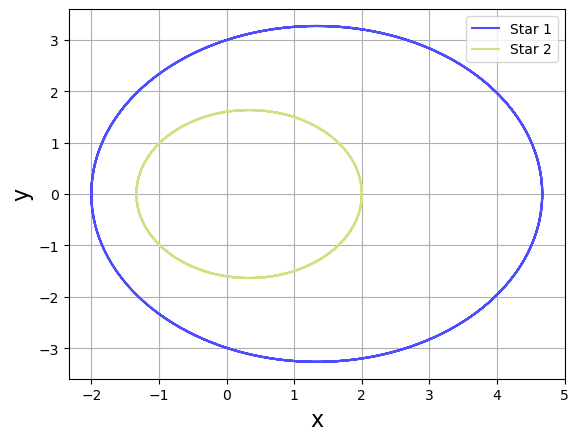

In [3]:
Star1 = Star(2.5, np.array([-2.0, 0.0]), np.array([0.0, 1.0]))
Star2 = Star(5.0, np.array([2.0, 0.0]), np.array([0.0, -0.5]))

Two_star_system = StellarSystem() # Here, we have set up an instance of the Stellar System class
Two_star_system.add_star(Star1)
Two_star_system.add_star(Star2)

Two_star_system.collate_initial_conditions()

Two_star_system.integrate_using_midpoint(100.0, 2000)

Two_star_system.plot_solution()

## 2.7 Testing the convergence of a second-order method

In this section, we shall show that the midpoint method trialled above converges. The midpoint method is a second-order method, so we must check whether it converges appropriately by (order $2^2$).

One can see that the finer resolutions (the green line) converge with the expected eror. Thus, we can confidently say that the midpoint method established in the StellarSystem class converges appropriately. 

The star with mass 0.5 units has successfully been added to your 1-star system situated in a galaxy far, far away!
The star with mass 1.0 units has successfully been added to your 2-star system situated in a galaxy far, far away!


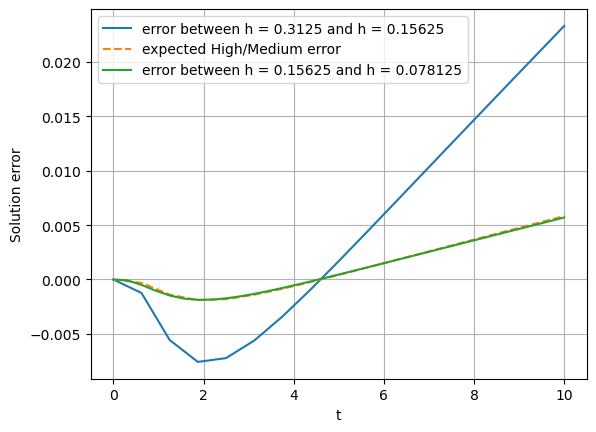

In [4]:
Star1 = Star(0.50, np.array([-1.0, 0.0]), np.array([0.0, 1.0]))
Star2 = Star(1.00, np.array([1.0, -0.0]), np.array([0.0, -0.5]))

Two_star_system = StellarSystem()

Two_star_system.add_star(Star1)
Two_star_system.add_star(Star2)

Two_star_system.collate_initial_conditions()

Two_star_system.integrate_using_midpoint(10.0, 200)

Two_star_system.test_convergence_of_midpoint(10.0, 200)

## 2.8 The Solve_ivp method

The solve_ivp method is displayed below. For more information on solve_ivp please see section 2.4 in the markdown above. 

The star with mass 0.4 units has successfully been added to your 1-star system situated in a galaxy far, far away!
The star with mass 0.8 units has successfully been added to your 2-star system situated in a galaxy far, far away!


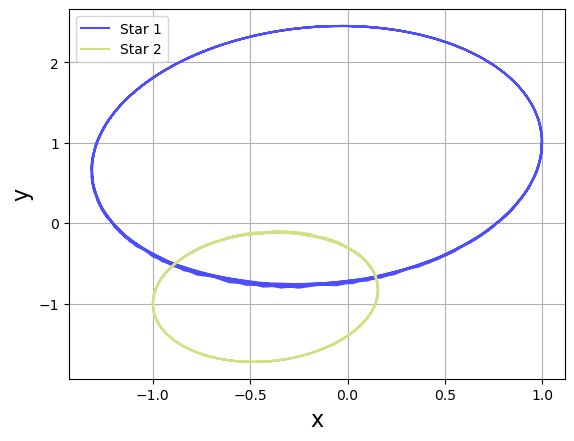

In [5]:
Star1 = Star(0.40, np.array([1.0, 1.0]), np.array([0.0, -0.40]))
Star2 = Star(0.80, np.array([-1.0, -1.0]), np.array([0.0, 0.20]))

Two_star_system = StellarSystem()

Two_star_system.add_star(Star1)
Two_star_system.add_star(Star2)

Two_star_system.collate_initial_conditions()

Two_star_system.integrate_using_solve_ivp(100.0, 200)

Two_star_system.plot_solution()



## 2.9 Phase plots of the stellar system

We shall now produce phase plots of our stars using the above solution. Phase plots show the velocity over the position. I have split these in two, as we have two dimensions to consider.

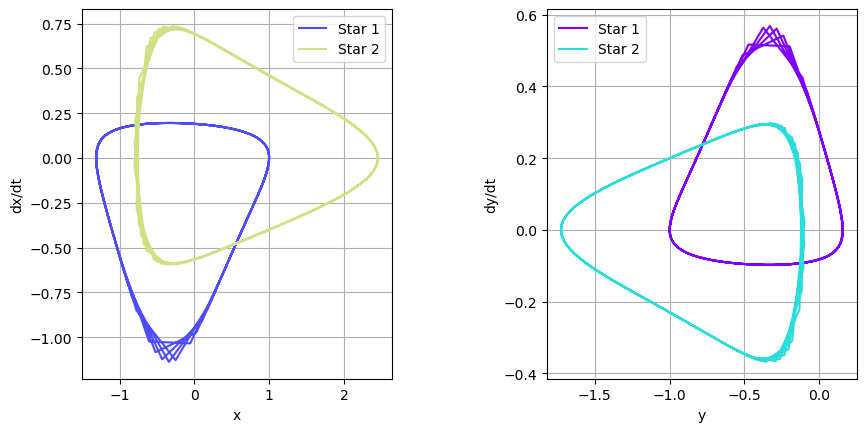

In [6]:
Two_star_system.plot_phase_portraits()

# 3.0 The three-body system

## 3.1 Stable three-body system

In this section, we will establish a three-body system by adding three stars to an instance of our StellarSystem class.

One may notice how precise the initial conditions are. This is because trinary star systems are extremely rare and often result in a possible ejection of one body from the dynamical system. With these conditions, found by Cris Moore and proved by Chenciner and Montgomery, described [in this article](https://arxiv.org/abs/math/0011268).

You will see a plot of the solution curves of the stable dynamical system below. In order to get smooth solution curves, we had to amend the rtol parameter of solve ivp from the default to 1e-10. The rtol parameter is the amount of error which solve_ivp permits before altering its step size. Obviously, the smaller the rtol parameter, the less error allowed. Hence, the smoother the solution curve.

Please do also note that - much like the other examples we have already explored - we have chosen values such that Newton's gravitational constant, G, is equal to one.

The star with mass 1.0 units has successfully been added to your 1-star system situated in a galaxy far, far away!
The star with mass 1.0 units has successfully been added to your 2-star system situated in a galaxy far, far away!
The star with mass 1.0 units has successfully been added to your 3-star system situated in a galaxy far, far away!


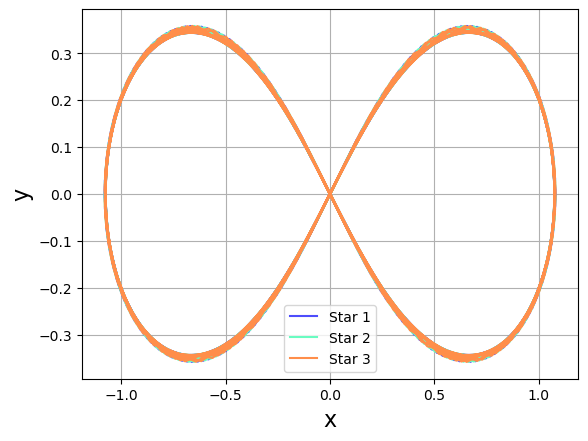

In [7]:
StarA = Star(1.0, np.array([0.97000436,-0.24308753]), np.array([0.93240737/2, 0.86473146/2]))
StarB = Star(1.0, np.array([-0.97000436, 0.24308753]), np.array([0.93240737/2, 0.86473146/2]))
StarC = Star(1.0, np.array([0.0, 0.0]), np.array([-0.93240737, -0.86473146]))

Three_star_system = StellarSystem()

Three_star_system.add_star(StarA)
Three_star_system.add_star(StarB)
Three_star_system.add_star(StarC)

Three_star_system.collate_initial_conditions()

Three_star_system.integrate_using_solve_ivp(50.0, 200)

Three_star_system.plot_solution()

## 3.2 Solve the stable system using the midpoint method

In this section, we explore the stable three-body system, but solve it using the midpoint method. This is so that we can compare both methods for solving the system of ODEs.

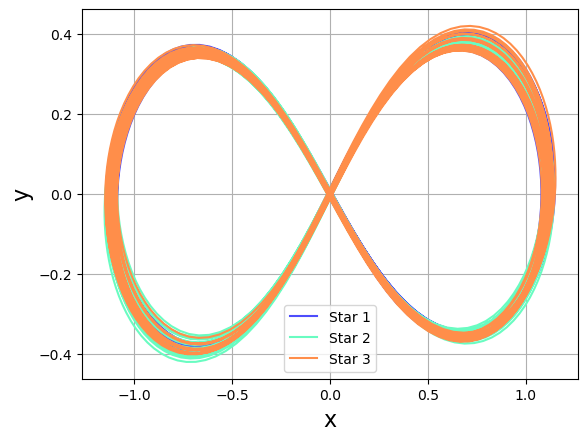

In [8]:
Three_star_system.integrate_using_midpoint(100, 2000)

Three_star_system.plot_solution()

## 3.3 Stable three-body system phase plot

Please see a phase portrait of the stable three body system.

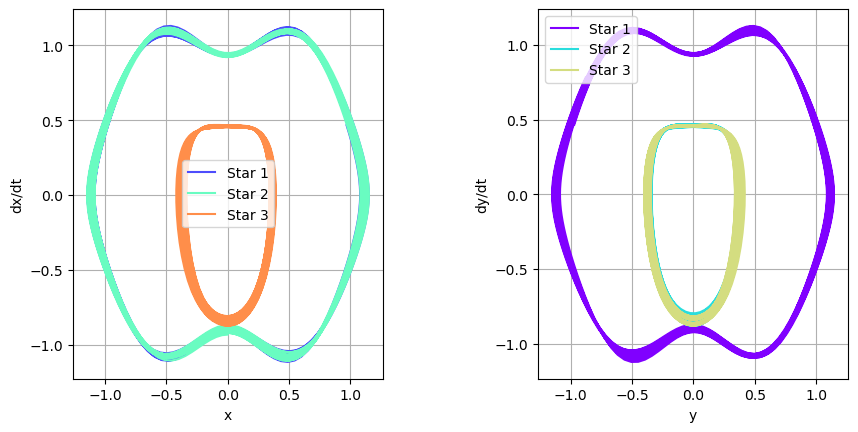

In [9]:
Three_star_system.plot_phase_portraits()

## 3.4 Unstable three-body system

Below, you will see the plot of a three-body system, which has one star escape. 


The star with mass 1.0 units has successfully been added to your 1-star system situated in a galaxy far, far away!
The star with mass 1.0 units has successfully been added to your 2-star system situated in a galaxy far, far away!
The star with mass 1.0 units has successfully been added to your 3-star system situated in a galaxy far, far away!


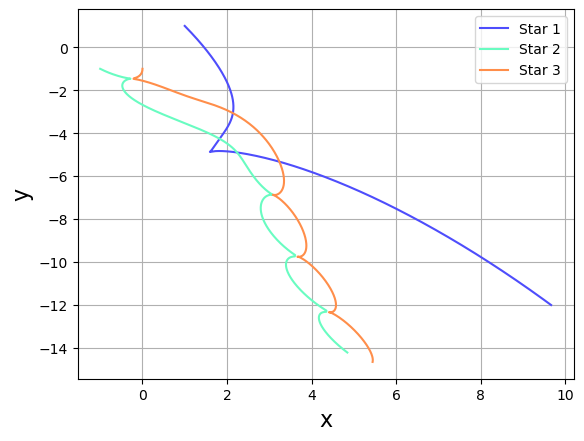

In [10]:
StarA = Star(1.0, np.array([1.0, 1.0]), np.array([1.0, -2.0]))
StarB = Star(1.0, np.array([-1.0, -1.0]), np.array([1.0, -1.0]))
StarC = Star(1.0, np.array([0.0, -1.0]), np.array([0.0, -1.0]))

Unstable_three_star_system = StellarSystem()

Unstable_three_star_system.add_star(StarA)
Unstable_three_star_system.add_star(StarB)
Unstable_three_star_system.add_star(StarC)

Unstable_three_star_system.collate_initial_conditions()

Unstable_three_star_system.integrate_using_solve_ivp(10.0, 500)

Unstable_three_star_system.plot_solution()

# 4.0 Hypergiants

In this section, we shall look at stars which become extremely massive. They may colide with other massive stars and form one giant star. Below, is my attempt at creating a hypergiantclass that inherits properties form the previously established star class. 



In [11]:
class Hypergiant(Star):
    
    """
    This is a class which holds information about larger stars, known as Hypergiants.
    Computationally, this is a class which has inherited its properties from the previously defined Star class.
    
    attributes: mass (of the star), position (of the star).
                
    There are no methods associated with this class. This is because the system of ODEs we need to solve are coupled.
    Therefore, we must collate the initial conditions of the system before we can solve the system. 
    
    """

    # The below function is our constructor function
    def __init__(self, mass=0.0, initial_position=np.array([0.0, 0.0]), 
                 initial_velocity=np.array([0.0, 0.0])):
        
        super().__init__(mass, initial_position, initial_velocity)
           
        assert mass >= 0.0, 'Mass of the hypergiant must be non-negative'
        assert np.shape(initial_position) == (2,), 'The initial position must be a 1 x 2 vector. The first element is the x-component of the displacement and the second element is the y-component of the displacement.' 
        assert np.shape(initial_velocity) == (2,), 'The initial position must be a 1 x 2 vector. The first element is the x-component of the velocity and the second element is the y-component of the velocity.' 
        
class hypergiants_stellar_system(StellarSystem):

    """
    This is a class which allows one to add stars to its system and contains explicit methods to
    integrate the ODEs provided for stellar orbits
    
    attributes: 
                
    methods: calculate_solution, plot_solution
    
    """
    
    # The below function is our constructor function
    def __init__(self):
        
        super().__init__()
        
        self.merge_time = 0.0
        self.merge_time_index = 0
        self._is_solved = False

    
    def combine_hypergiants(self, aStar, bStar, merge_time):
            
            if aStar.mass == 0.0:
                
                return
            elif bStar.mass == 0.0:
                return
            else:
                
                print(f"Your hypergiant with {aStar.mass} unit(s) has collided with another hypergiant of mass {bStar.mass} units to become a hypergiant with mass {aStar.mass + bStar.mass} units at point ({aStar._solution_x_position[merge_time]}, {aStar._solution_y_position[merge_time]}).")

                aStar._solution_x_velocity[merge_time] = (aStar._solution_x_velocity[merge_time]*aStar.mass + bStar._solution_x_velocity[merge_time]*bStar.mass) / (aStar.mass + bStar.mass)
            
                aStar._solution_y_velocity[merge_time] = (aStar._solution_y_velocity[merge_time]*aStar.mass + bStar._solution_y_velocity[merge_time]*bStar.mass) / (aStar.mass + bStar.mass)
            
                aStar.mass = aStar.mass + bStar.mass
        
                bStar.mass = 0.0
            
                bStar._solution_y_velocity[merge_time] = 0.0
            
                bStar._solution_x_velocity[merge_time] = 0.0
                
                    
    def integrate_using_solve_ivp_hypergiants(self, max_time, time_steps):
        """Returns the solution curve for the given dydt function using solve_ivp"""
            
        assert isinstance(max_time, (float, int)), 'The maximum time that you wish the solution to be solved for (max_time) must be an integer or floating point number.'
        assert max_time > 0.0, 'The maximum time that you wish the solution to be solved for (max_time) must be positive'
        assert isinstance(time_steps, int), 'The number of steps that you require the solution to be solved for must be an integer'
        assert time_steps > 0, 'The number of steps that you require the solution to be solved for must be positive'
        assert self._is_initialised is True, 'You must first collate the initial conditions of each star before solving. Use the self.collate_initial_conditions() method BEFORE attempting to solve with solve_ivp or midpoint.'
        
        
        delta_t = max_time / time_steps
        t_solution = np.linspace(0.0, max_time-delta_t, time_steps) # values of independent variable 
        
        
        solution = solve_ivp(self.calculate_stellar_system_dydt, [0,max_time],self.initial_conditions , method='RK45', t_eval=t_solution)
        
        for iStar, bStar in enumerate(self.stars) :
            
            bStar._solution_x_velocity = solution.y[4* iStar]
            bStar._solution_x_position = solution.y[4* iStar + 1]
            
            bStar._solution_y_velocity = solution.y[4 * iStar + 2]
            bStar._solution_y_position = solution.y[4 * iStar + 3]
            
        
        self._solution_y = solution.y
        self._solution_t = solution.t
        self._is_solved = True
        
        for iStar, bStar in enumerate(self.stars) :
            for jStar, aStar in enumerate(self.stars):
                if jStar == iStar:
                    continue

                else:
                    for itime, time in enumerate(solution.t):
                        if itime == 0:
                                continue
                        else:
                                if np.hypot(abs(aStar._solution_x_position[itime]) - abs(bStar._solution_x_position[itime]), abs(aStar._solution_y_position[itime]) - abs(bStar._solution_y_position[itime])) < 0.5:
                                    self.merge_time = time
                                    self.merge_time_index = itime
                                    delta_t = max_time / time_steps                        
                                    self.combine_hypergiants(aStar, bStar, self.merge_time_index)
                                    break
                            
                                else:
                                    continue
        


        for iStar, bStar in enumerate(self.stars) :
            
            self.initial_conditions[4 * iStar] = solution.y[4 * iStar][self.merge_time_index]
            self.initial_conditions[4 * iStar + 1] = solution.y[4 * iStar + 1][self.merge_time_index]
                    
            self.initial_conditions[4 * iStar + 2] = solution.y[4 * iStar + 2][self.merge_time_index]      
            self.initial_conditions[4 * iStar + 3] = solution.y[4 * iStar + 3][self.merge_time_index]
            
        post_merge_t_solution = np.linspace(self.merge_time, max_time-delta_t, time_steps+1) # values of independent variable 
                
        post_merge_solution = solve_ivp(self.calculate_stellar_system_dydt, [self.merge_time, max_time],self.initial_conditions, method='RK45', t_eval=post_merge_t_solution)
        print(f"The time at which these stars merged was at {self.merge_time} time units")
            
        for itime, time in enumerate(solution.t):
            
            if time < self.merge_time:
                    
                    for iStar, bStar in enumerate(self.stars) :

                        self._solution_y[4 * iStar][itime] = solution.y[4 * iStar][itime]
                        self._solution_y[4 * iStar + 1][itime] = solution.y[4 * iStar + 1][itime]
            
                        self._solution_y[4 * iStar + 2][itime] = solution.y[4 * iStar + 2][itime]
                        self._solution_y[4 * iStar + 3][itime] = solution.y[4 * iStar + 3][itime]
            
            else:
                            
                    for iStar, bStar in enumerate(self.stars) :
                        
                        self._solution_y[4 * iStar][itime] = post_merge_solution.y[4 * iStar][itime]
                        self._solution_y[4 * iStar + 1][itime] = post_merge_solution.y[4 * iStar + 1][itime]
            
                        self._solution_y[4 * iStar + 2][itime] = post_merge_solution.y[4 * iStar + 2][itime]
                        self._solution_y[4 * iStar + 3][itime] = post_merge_solution.y[4 * iStar + 3][itime]
            
        
        return self._solution_y, 
        return solution.t
            
    

## 4.1 Instances of merging hypergiants

In this section, you will see the creation of hypergiant objects and my attempt at making them merge at some point.

I did not achieve this, unfortunately. However, the plan was to check the proximity of the hypergiants to each other. If two get sufficiently close (checked by using the above 'hypot' method), I wanted to add together the colliding masses together, amend the velocity of one star such that momentum is conserved (according to $m_1v_1 = m_2v_2$), and turn one colliding star's mass to zero (therefore inhibiting that star from having any more impact on the rest of the system) - as I have attempted in my 'collide_hypergiants' method defined above. However, I have not succeeded here. The reason I believe is that I have misassigned values so that the 'hypot' method is not actually checking the stars' positions. 

The star with mass 0.4 units has successfully been added to your 1-star system situated in a galaxy far, far away!
The star with mass 0.5 units has successfully been added to your 2-star system situated in a galaxy far, far away!
The star with mass 0.6 units has successfully been added to your 3-star system situated in a galaxy far, far away!
Your hypergiant with 0.5 unit(s) has collided with another hypergiant of mass 0.4 units to become a hypergiant with mass 0.9 units at point (-1.2288612459651616, 2.804270233700455).
The time at which these stars merged was at 3.95 time units


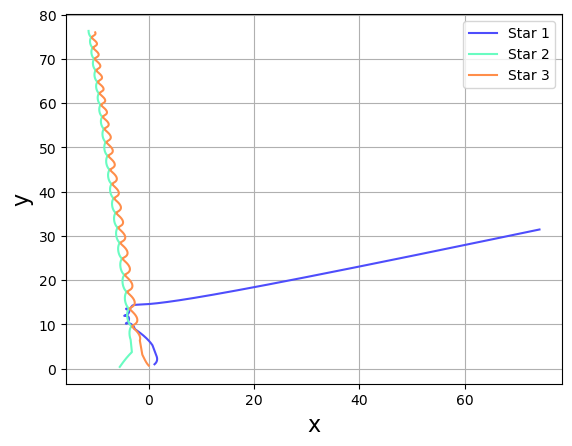

In [12]:
HyperGiant1 = Hypergiant(0.40, np.array([1.1,1.0]), np.array([0.5, 0.5]))
HyperGiant2 = Hypergiant(0.50, np.array([-5.5, 0.4]), np.array([0.5, 0.86]))
HyperGiant3 = Hypergiant(0.60, np.array([0.0, 0.7]), np.array([-0.5, 0.6]))

HyperGiant_star_system = hypergiants_stellar_system()

HyperGiant_star_system.add_star(HyperGiant1)
HyperGiant_star_system.add_star(HyperGiant2)
HyperGiant_star_system.add_star(HyperGiant3)

HyperGiant_star_system.collate_initial_conditions()

HyperGiant_star_system.integrate_using_solve_ivp_hypergiants(100.0, 2000)

HyperGiant_star_system.plot_solution()


# 5.0 Error tests

In this section, we look at various error tests for the various methods and classes defined above. This inspired many asserts found throughout the code as it allowed me to think of ways in whcih the user could break the code. It also gave me the opportunity to understand the importance of setting up instance checks to make sure users aren't passing in inappropriate values when calling a method.  

## 5.1 A star with a non-floating point mass

In [14]:
#Star1 = Star("a", np.array([-2.0, 0.0]), np.array([0.0, 1.0]))

## 5.2 A star with a three-dimensional initial velocity

In [15]:
#Star2 = Star(1.0, np.array([-2.0, 3.0]), np.array([0.0, 1.0, 4.0]))

## 5.3 A star with a one-dimensional initial position

In [16]:
#Star3 = Star(1.0, np.array([-2.0]), np.array([0.0, 1.0]))

## 5.5 A star with a string as an element of the initial position

In [17]:
#Star4 = Star(1.0, np.array([-2.0, "a"]), np.array([0.0, 1.0]))

## 5.6 Removing a non-star from a system

In [18]:
#Two_star_system = StellarSystem()
#Two_star_system.remove_star(FakeStar)

## 5.7 Adding a non-star to a system

In [20]:
#Two_star_system = StellarSystem()
#Two_star_system.add_star(FakeStar)

## 5.8 Solve_ivp with non-positive time

In [22]:
#Star1 = Star(0.40, np.array([1.0, 1.0]), np.array([0.0, -0.40]))
#Star2 = Star(0.80, np.array([-1.0, -1.0]), np.array([0.0, 0.20]))

#Two_star_system = StellarSystem()

#Two_star_system.add_star(Star1)
#Two_star_system.add_star(Star2)

#Two_star_system.collate_initial_conditions()

#Two_star_system.integrate_using_solve_ivp(-100.0, 200)

## 5.9 Midpoint method with non-integer time steps

In [24]:
#Star1 = Star(2.5, np.array([-2.0, 0.0]), np.array([0.0, 1.0]))
#Star2 = Star(5.0, np.array([2.0, 0.0]), np.array([0.0, -0.5]))

#Two_star_system = StellarSystem()
#Two_star_system.add_star(Star1)
#Two_star_system.add_star(Star2)

#Two_star_system.collate_initial_conditions()

#Two_star_system.integrate_using_midpoint(100.0, 2000.5)

## 5.10 Midpoint method with string-valued time steps

In [ ]:
#Star1 = Star(2.5, np.array([-2.0, 0.0]), np.array([0.0, 1.0]))
#Star2 = Star(5.0, np.array([2.0, 0.0]), np.array([0.0, -0.5]))

#Two_star_system = StellarSystem()
#Two_star_system.add_star(Star1)
#Two_star_system.add_star(Star2)

#Two_star_system.collate_initial_conditions()

#Two_star_system.integrate_using_midpoint(100.0, "steps")

## 5.11 Attempt to solve the system before collating initial conditions

In [26]:
#Star1 = Star(0.40, np.array([1.0, 1.0]), np.array([0.0, -0.40]))
#Star2 = Star(0.80, np.array([-1.0, -1.0]), np.array([0.0, 0.20]))

#Two_star_system = StellarSystem()

#Two_star_system.add_star(Star1)
#Two_star_system.add_star(Star2)

#Two_star_system.integrate_using_solve_ivp(100.0, 200)

#Two_star_system.collate_initial_conditions()

## 5.12 Attempt to plot the system before solving

In [28]:
#Star1 = Star(0.40, np.array([1.0, 1.0]), np.array([0.0, -0.40]))
#Star2 = Star(0.80, np.array([-1.0, -1.0]), np.array([0.0, 0.20]))

#Two_star_system = StellarSystem()

#Two_star_system.add_star(Star1)
#Two_star_system.add_star(Star2)

#Two_star_system.collate_initial_conditions()

#Two_star_system.plot_solution()

#Two_star_system.integrate_using_solve_ivp(100.0, 200)